<a href="https://colab.research.google.com/github/joseandresv/Bayes-MCMC-wEmbeddings/blob/main/MCMC_Embed_Compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
data = pd.read_csv("/content/gdrive/MyDrive/MCC/Métodos analíticos /wines_with_description.csv", delimiter=',')
data.head()

,judge,flight,wine,score,wine.amer,judge.amer,description
0,Jean-M Cardebat,white,A1,10.0,1,0,"After hand-picking, whole cluster pressing, an..."
1,Jean-M Cardebat,white,B1,13.0,1,0,This enticing Sauvignon Blanc offers a beautif...
2,Jean-M Cardebat,white,C1,14.0,0,0,Our 2013 Gewurztraminer displays classic rose ...
3,Jean-M Cardebat,white,D1,15.0,0,0,"""Light gold. A stunning bouquet offers powerfu..."
4,Jean-M Cardebat,white,E1,8.0,1,0,This is perhaps the most elegant Chardonnay ev...


In [24]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

import torch
def get_bert_embeddings(text):
    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    with torch.no_grad():
        # Get the hidden states from BERT
        outputs = model(**inputs)
    # Get the embeddings from the last hidden state (or you can use other layers or combinations)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

data['embeddings'] = data['description'].apply(lambda x: get_bert_embeddings(x).squeeze().numpy())

In [25]:
# Factorize judge and wine columns
data['judge_num'] = pd.factorize(data['judge'])[0] + 1
data['wine_num'] = pd.factorize(data['wine'])[0] + 1

# Normalize the score
mean_score = data['score'].mean()
std_score = data['score'].std()
data['score_est'] = (data['score'] - mean_score) / std_score

# Display the resulting DataFrame
data.head()

,judge,flight,wine,score,wine.amer,judge.amer,description,embeddings
0,Jean-M Cardebat,white,A1,10.0,1,0,"After hand-picking, whole cluster pressing, an...","[0.14796719, -0.020186903, -0.3261488, 0.12357..."
1,Jean-M Cardebat,white,B1,13.0,1,0,This enticing Sauvignon Blanc offers a beautif...,"[0.1402151, 0.0060550207, -0.14806426, -0.0974..."
2,Jean-M Cardebat,white,C1,14.0,0,0,Our 2013 Gewurztraminer displays classic rose ...,"[0.09549883, -0.00827736, -0.096210316, 0.0641..."
3,Jean-M Cardebat,white,D1,15.0,0,0,"""Light gold. A stunning bouquet offers powerfu...","[0.12561646, 0.07308795, -0.007863807, 0.09365..."
4,Jean-M Cardebat,white,E1,8.0,1,0,This is perhaps the most elegant Chardonnay ev...,"[-0.004704587, 0.100614175, -0.34878105, -0.13..."


In [26]:
# Extract unique counts and initialize variables
n_judges = data['judge'].nunique()
n_wines = data['wine'].nunique()
n_scores = len(data)
n_origins = data['wine.amer'].nunique()
n_judge_origins = data['judge.amer'].nunique()

# Prepare the wine data list dictionary
wine_data_list = {
    'n_judges': n_judges,
    'n_wines': n_wines,
    'N': n_scores,
    'S': data['score_est'].values,
    'wine': data['wine_num'].values,
    'judge': data['judge_num'].values,
    'n_origins': n_origins,
    'origins': data['wine.amer'].values,
    'n_judge_origins': n_judge_origins,
    'judge_origins': data['judge.amer'].values
}

# Extracting the data into variables
S = wine_data_list['S']
wine = wine_data_list['wine']
judge = wine_data_list['judge']
origin = wine_data_list['origins']
judge_origin = wine_data_list['judge_origins']

In [61]:
with pm.Model() as wine_model_simple_origins:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    O = pm.Normal('O', mu=0, sigma=1, shape=n_origins)
    J = pm.Normal('J', mu=0, sigma=1, shape=n_judge_origins)
    JO = pm.Normal('JO', mu=0, sigma=1, shape=(n_judge_origins, n_origins))
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = (
        Q[wine-1] +
        O[origin-1] +
        J[judge_origin-1] +
        JO[judge_origin-1, origin-1]
        ) # Python is 0-indexed

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)
    simple_o_dag = pm.model_to_graphviz(wine_model_simple_origins)

    trace_simple_o = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9, # Adjust acceptance rate to affect step size
        return_inferencedata=True # Ensure log_likelihood is included
    )

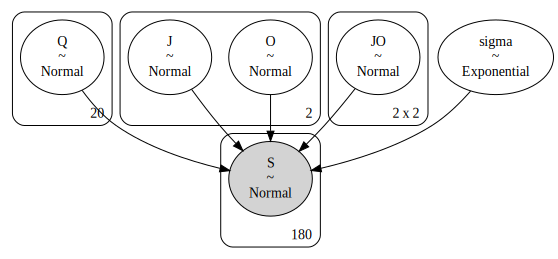

In [44]:
simple_o_dag

In [62]:
mean_embeddings = np.vstack(data['embeddings'].values).mean(axis=0)
mean_description_shape = mean_embeddings.shape[0]

with pm.Model() as wine_model_mean_embeddings:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    O = pm.Normal('O', mu=0, sigma=1, shape=n_origins)
    J = pm.Normal('J', mu=0, sigma=1, shape=n_judge_origins)
    JO = pm.Normal('JO', mu=0, sigma=1, shape=(n_judge_origins, n_origins))
    beta = pm.Normal('beta', mu=0, sigma=1, shape=mean_description_shape)  # Embedding coefficient
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = (
        Q[wine-1] +
        O[origin-1] +
        J[judge_origin-1] +
        JO[judge_origin-1, origin-1] +
        pm.math.dot(beta, mean_embeddings)
        )

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)
    mean_embeddings_dag = pm.model_to_graphviz(wine_model_simple_origins)

    trace_mean_embeddings = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9, # Adjust acceptance rate to affect step size
        return_inferencedata=True # Ensure log_likelihood is included
    )

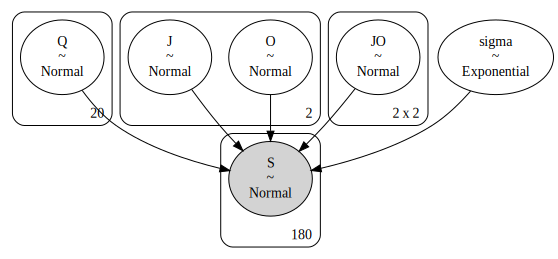

In [39]:
mean_embeddings_dag

In [63]:
pca = PCA(n_components=10)  # Adjust the number of components as needed
pca_embeddings = pca.fit_transform(np.vstack(data['embeddings'].values))

for i in range(pca_embeddings.shape[1]):
    data[f'pca_{i+1}'] = pca_embeddings[:, i]

pca_features = data[[f'pca_{i+1}' for i in range(pca_embeddings.shape[1])]].values

with pm.Model() as wine_model_pca:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    O = pm.Normal('O', mu=0, sigma=1, shape=n_origins)
    J = pm.Normal('J', mu=0, sigma=1, shape=n_judge_origins)
    JO = pm.Normal('JO', mu=0, sigma=1, shape=(n_judge_origins, n_origins))
    beta = pm.Normal('beta', mu=0, sigma=1, shape=pca_features.shape[1])  # PCA coefficients
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = (
        Q[wine-1] +
        O[origin-1] +
        J[judge_origin-1] +
        JO[judge_origin-1, origin-1] +
        pm.math.dot(beta, pca_features[wine-1].T)
        )

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)
    pca_dag = pm.model_to_graphviz(wine_model_simple_origins)

    trace_pca = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9, # Adjust acceptance rate to affect step size
        return_inferencedata=True # Ensure log_likelihood is included

    )

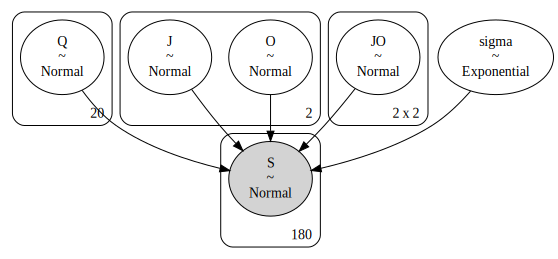

In [41]:
pca_dag

Model Compare with log-likelihood and posterior predictive checks

In [86]:
with wine_model_simple_origins:
    pm.compute_log_likelihood(trace_simple_o)

with wine_model_mean_embeddings:
    pm.compute_log_likelihood(trace_mean_embeddings)

with wine_model_pca:
    pm.compute_log_likelihood(trace_pca)


wine_model_simple_origins_loo = az.loo(trace_simple_o)
wine_model_mean_embeddings_loo = az.loo(trace_mean_embeddings)
wine_model_mean_embeddings_loo = az.loo(trace_pca)


ValueError: ['log_likelihood'] group(s) already exists.

In [87]:
df_comp_loo = az.compare({"simple": trace_simple_o, "mean": trace_mean_embeddings, "pca": trace_pca})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mean,0,-265.216173,19.874079,0.000000,1.000000e+00,8.381163,0.000000,False,log
simple,1,-265.344892,19.987315,0.128719,3.330669e-16,8.385492,0.091770,False,log
pca,2,-266.046354,20.579399,0.830181,0.000000e+00,8.397438,0.335547,False,log


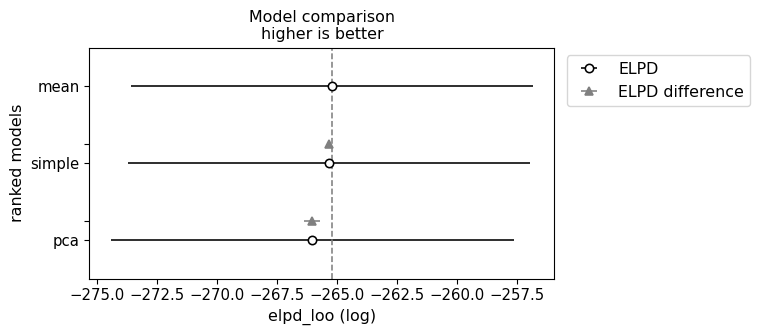

In [88]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [95]:
with wine_model_simple_origins:
  ppc_simple_o = pm.sample_posterior_predictive(trace_simple_o, extend_inferencedata=True, var_names=["S"])

with wine_model_mean_embeddings:
  ppc_mean_embeddings = pm.sample_posterior_predictive(trace_mean_embeddings, extend_inferencedata=True, var_names=["S"])

with wine_model_pca:
  ppc_pca = pm.sample_posterior_predictive(trace_pca, extend_inferencedata=True, var_names=["S"])


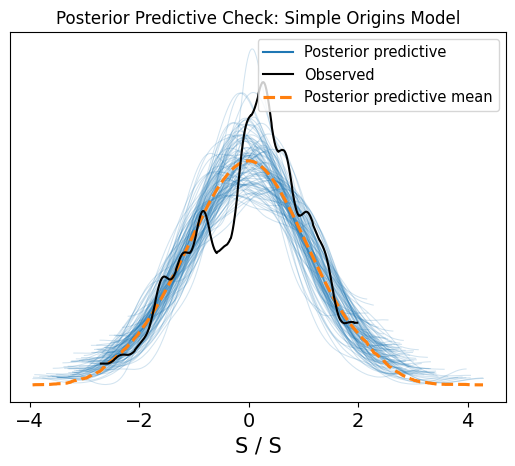

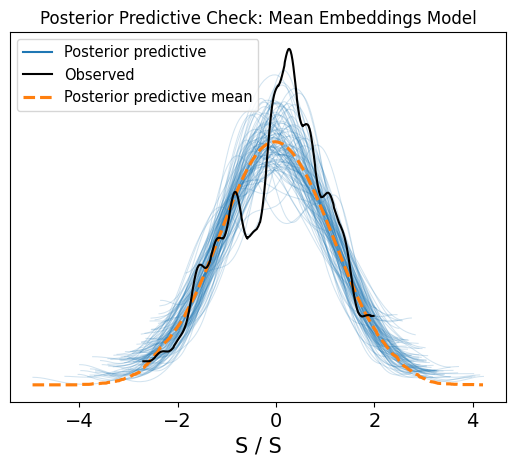

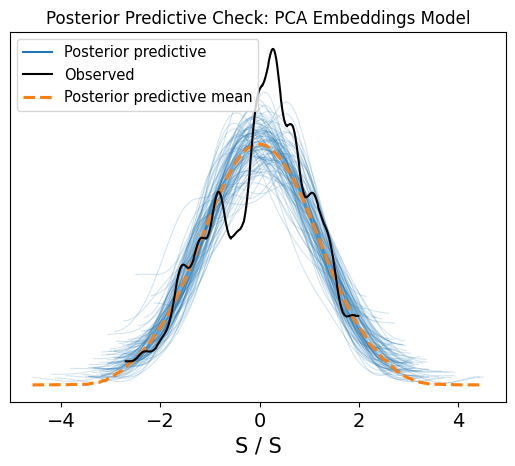

In [101]:
fig, ax = plt.subplots()
az.plot_ppc(trace_simple_o, num_pp_samples=100, ax=ax);
ax.set_title("Posterior Predictive Check: Simple Origins Model")
plt.show()

fig, ax = plt.subplots()
az.plot_ppc(trace_mean_embeddings, num_pp_samples=100, ax=ax);
ax.set_title("Posterior Predictive Check: Mean Embeddings Model")
plt.show()

fig, ax = plt.subplots()
az.plot_ppc(trace_pca, num_pp_samples=100, ax=ax);
ax.set_title("Posterior Predictive Check: PCA Embeddings Model")
plt.show()